In [ ]:

import numpy as np
import nibabel as nib
import glob
import tensorflow as tf
import keras
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave
from sklearn.preprocessing import MinMaxScaler
import random as r

In [ ]:
import os
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.metrics import MeanIoU

In [ ]:
print(np.unique(test_mask))
mask[test_mask==4] = 3  #Reassign mask values 4 to 3
print(np.unique(test_mask))


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
!unzip /content/tam_veri/BraTS2020_TrainingData.zip

Archive:  /content/tam_veri/BraTS2020_TrainingData.zip
  inflating: BraTS2020_TrainingData/combined255.npy  
   creating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/
   creating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t2.nii  
   creating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_Trai

In [ ]:
TRAIN_DATASET_PATH = '/content/train/'

In [ ]:
base_path = "/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
flair = sorted(glob.glob(base_path + "/**/*flair.nii", recursive=True))
t1 = sorted(glob.glob(base_path + "/**/*t1.nii", recursive=True))
t1ce = sorted(glob.glob(base_path + "/**/*t1ce.nii", recursive=True))
t2 = sorted(glob.glob(base_path + "/**/*t2.nii", recursive=True))
mask = sorted(glob.glob(base_path + "/**/*seg.nii", recursive=True))

1057.0
[0 1 2 4]
[0 1 2 3]


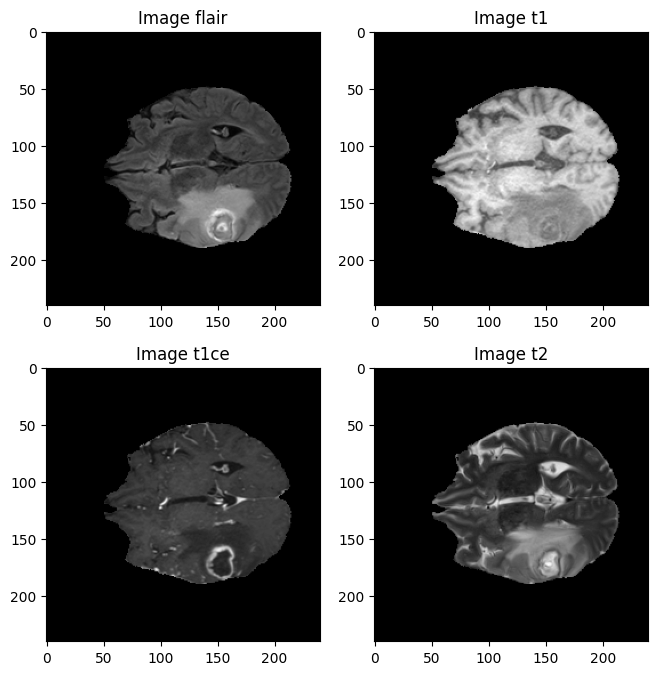

In [ ]:
TRAIN_DATASET_PATH = '/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'


test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_055/BraTS20_Training_055_flair.nii').get_fdata()
print(test_image_flair.max())

test_image_flair=scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)


test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_055/BraTS20_Training_055_t1.nii').get_fdata()
test_image_t1=scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_055/BraTS20_Training_055_t1ce.nii').get_fdata()
test_image_t1ce=scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_055/BraTS20_Training_055_t2.nii').get_fdata()
test_image_t2=scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_055/BraTS20_Training_055_seg.nii').get_fdata()
test_mask=test_mask.astype(np.uint8)

print(np.unique(test_mask))  #0, 1, 2, 4 (Need to reencode to 0, 1, 2, 3)
test_mask[test_mask==4] = 3  #Reassign mask values 4 to 3
print(np.unique(test_mask))

n_slice=65

plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(test_image_t1[:,:,n_slice], cmap='gray')
plt.title('Image t1')
plt.subplot(234)
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(235)
plt.imshow(test_image_t2[:,:,n_slice], cmap='gray')
plt.title('Image t2')

plt.show()



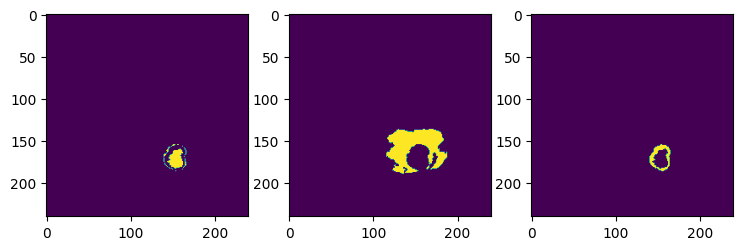

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(242)
plt.imshow(test_mask[:,:,n_slice]==1)
plt.subplot(243)
plt.imshow(test_mask[:,:,n_slice]==2)
plt.subplot(244)
plt.imshow(test_mask[:,:,n_slice]==3)
plt.show()

In [ ]:
for img in range(150,200):
    print("Now preparing image and masks number: ", img)

    temp_image_t2=nib.load(t2[img]).get_fdata()
    temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)

    temp_image_t1ce=nib.load(t1ce[img]).get_fdata()
    temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)

    temp_image_flair=nib.load(flair[img]).get_fdata()
    temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)

    temp_mask=nib.load(mask[img]).get_fdata()
    temp_mask=temp_mask.astype(np.uint8)
    temp_mask[temp_mask==4] = 3


    temp_combined_images = np.stack([temp_image_flair,temp_image_t1ce, temp_image_t2], axis=3)



    temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]

    val, counts = np.unique(temp_mask, return_counts=True)


    print("Save Me")
    temp_mask= to_categorical(temp_mask, num_classes=4)
    np.save('/content/tamV/images/image_'+str(img)+'.npy', temp_combined_images)
    np.save('/content/tamV/masks/mask_'+str(img)+'.npy', temp_mask)



In [ ]:

from keras.layers import Input, Conv3D, MaxPooling3D, Dropout, Conv3DTranspose, concatenate
from keras.models import Model

kernel_initializer = 'he_uniform'  # Try others if you want

def attention_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    s = inputs

    # Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)

    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)

    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)

    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)

    # Expansive path
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)

    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    att7 = attention_block(c3, u7)
    u7 = concatenate([u7, att7])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)

    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    att8 = attention_block(c2, u8)
    u8 = concatenate([u8, att8])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)

    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    att9 = attention_block(c1, u9)
    u9 = concatenate([u9, att9])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)

    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.summary()
    return model

def attention_block(g, x, inter_channel=32):
    # Attention Mechanism
    theta_g = Conv3D(inter_channel, (1, 1, 1), activation='relu', kernel_initializer=kernel_initializer, padding='same')(g)
    phi_x = Conv3D(inter_channel, (1, 1, 1), activation='relu', kernel_initializer=kernel_initializer, padding='same')(x)
    f = Conv3D(inter_channel, (1, 1, 1), activation='relu', kernel_initializer=kernel_initializer, padding='same')(x)

    theta_g = tf.keras.layers.Reshape((-1, inter_channel))(theta_g)
    phi_x = tf.keras.layers.Reshape((-1, inter_channel))(phi_x)
    f = tf.keras.layers.Reshape((-1, inter_channel))(f)

    # compute attention score
    theta_phi = tf.keras.layers.dot([theta_g, phi_x], axes=(2, 2))
    attention = tf.keras.layers.Activation('softmax')(theta_phi)
    f = tf.keras.layers.dot([attention, f], axes=(2, 1))
    f = tf.keras.layers.Reshape((g.shape[1], g.shape[2], g.shape[3], inter_channel))(f)

    adjust_channels = Conv3D(inter_channel, (1, 1, 1), activation='relu', kernel_initializer=kernel_initializer, padding='same')(x)
    x = tf.keras.layers.Activation('sigmoid')(x)
    x = tf.keras.layers.multiply([x, g])

    return x



model = attention_unet_model(128, 128, 128, 3, 4)
print(model.input_shape)
print(model.output_shape)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d_15 (Conv3D)             (None, 128, 128, 12  1312        ['input_2[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout_6 (Dropout)            (None, 128, 128, 12  0           ['conv3d_15[0][0]']              
                                8, 16)                                                        

In [ ]:
def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):
        if (image_name.split('.')[1] == 'npy'):

            image = np.load(img_dir+image_name)

            images.append(image)
    images = np.array(images)

    return(images)




def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)


    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)

            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y)

            batch_start += batch_size
            batch_end += batch_size


In [ ]:
import numpy as np

def load_imgV(img_dir, img_list):
    images = []
    for i, image_name in enumerate(img_list):
        if image_name.split('.')[1] == 'npy':
            image = np.load(img_dir + image_name)
            images.append(image)
    images = np.array(images)
    return images

def imageLoaderV(img_dir, img_list, batch_size):
    L = len(img_list)


    while True:
        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)

            X = load_img(img_dir, img_list[batch_start:limit])

            yield X

            batch_start += batch_size
            batch_end += batch_size


In [ ]:
train_img_dir = "/content/tamV/images/"
train_mask_dir = "/content/tamV/masks/"

val_img_dir = "/content/tamVal/images/"
val_mask_dir = "/content/tamVal/masks/"

train_img_list=os.listdir(train_img_dir)
train_mask_list=os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

In [ ]:
val_img_list

['image_91.npy',
 'image_91.npy',
 'image_81.npy',
 'image_92.npy',
 'image_99.npy',
 'image_98.npy',
 'image_86.npy',
 'image_84.npy',
 'image_97.npy',
 'image_82.npy',
 'image_87.npy',
 'image_90.npy',
 'image_80.npy',
 'image_89.npy',
 'image_88.npy',
 'image_85.npy',
 'image_94.npy',
 'image_83.npy',
 'image_93.npy',
 'image_95.npy',
 'image_96.npy']

In [ ]:
batch_size = 2
train_img_datagen = imageLoader(train_img_dir, train_img_list,
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list,
                                val_mask_dir, val_mask_list, batch_size)


In [ ]:
train_img_datagen=val_img_datagen

In [ ]:
img, msk = train_img_datagen.__next__()

In [ ]:
img.shape

(2, 128, 128, 128, 3)

In [ ]:
msk.shape

(2, 128, 128, 128, 4)

In [ ]:
import pandas as pd
columns = ['0','1', '2', '3']
df = pd.DataFrame(columns=columns)
train_mask_list = sorted(glob.glob('/content/tamV/masks/*.npy'))
for img in range(len(train_mask_list)):
    print(img)
    temp_image=np.load(train_mask_list[img])
    temp_image = np.argmax(temp_image, axis=3)
    val, counts = np.unique(temp_image, return_counts=True)
    zipped = zip(columns, counts)
    conts_dict = dict(zipped)

    df = df.append(conts_dict, ignore_index=True)

label_0 = df['0'].sum()
label_1 = df['1'].sum()
label_2 = df['1'].sum()
label_3 = df['3'].sum()
total_labels = label_0 + label_1 + label_2 + label_3
n_classes = 4

wt0 = round((total_labels/(n_classes*label_0)), 2)
wt1 = round((total_labels/(n_classes*label_1)), 2)
wt2 = round((total_labels/(n_classes*label_2)), 2)
wt3 = round((total_labels/(n_classes*label_3)), 2)

0
1
2


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


3
4
5


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


6
7
8


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


9
10
11


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


12
13
14


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


15
16
17


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


18
19
20


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


21
22
23


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


24
25
26


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


27
28
29


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


30
31
32


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


33
34
35


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


36
37
38


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


39
40
41


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


42
43
44


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


45
46
47


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


48
49
50


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future

51
52
53


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


54
55
56


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


57
58
59


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


60
61
62


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


63
64
65


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


66
67
68


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


69
70
71


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


72
73
74


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


75
76
77


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


78
79
80


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


81
82


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


83
84
85


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


86
87
88


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


89
90
91


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


92
93
94


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


95
96
97


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


98
99
100


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


101
102
103


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


104
105
106


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


107
108
109


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


110
111
112


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


113
114
115


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


116
117
118


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


119
120
121


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


122
123
124


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


125
126
127


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


128
129
130


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


131
132
133


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


134
135
136


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


137
138
139


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


140
141
142


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


143
144
145


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


146
147
148


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


149
150
151
152


<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-13-89fee347ab30>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


In [ ]:

import segmentation_models_3D as sm
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25,0.25,0.25,0.25]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)

In [ ]:
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size


In [ ]:
model7 = attention_unet_model(IMG_HEIGHT=128,
                          IMG_WIDTH=128,
                          IMG_DEPTH=128,
                          IMG_CHANNELS=3,
                          num_classes=4)

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d_232 (Conv3D)            (None, 128, 128, 12  1312        ['input_9[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout_69 (Dropout)           (None, 128, 128, 12  0           ['conv3d_232[0][0]']             
                                8, 16)                                                      

In [ ]:
model7.compile(optimizer = optim, loss=total_loss, metrics=metrics)

In [ ]:
print(model.input_shape)
print(model.output_shape)

(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)


In [ ]:
history4=model4.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=50,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

Epoch 1/50
76/76 [==============================] - 111s 1s/step - loss: 0.9524 - accuracy: 0.9291 - iou_score: 0.2207 - val_loss: 0.9407 - val_accuracy: 0.9505 - val_iou_score: 0.2334
Epoch 2/50
76/76 [==============================] - 105s 1s/step - loss: 0.9401 - accuracy: 0.9505 - iou_score: 0.2346 - val_loss: 0.9426 - val_accuracy: 0.9505 - val_iou_score: 0.2174
Epoch 3/50
76/76 [==============================] - 103s 1s/step - loss: 0.9387 - accuracy: 0.9502 - iou_score: 0.2343 - val_loss: 0.9391 - val_accuracy: 0.9505 - val_iou_score: 0.2254
Epoch 4/50
76/76 [==============================] - 102s 1s/step - loss: 0.9378 - accuracy: 0.9504 - iou_score: 0.2322 - val_loss: 0.9394 - val_accuracy: 0.9505 - val_iou_score: 0.2190
Epoch 5/50
76/76 [==============================] - 102s 1s/step - loss: 0.9369 - accuracy: 0.9508 - iou_score: 0.2315 - val_loss: 0.9373 - val_accuracy: 0.9505 - val_iou_score: 0.2247
Epoch 6/50
76/76 [==============================] - 101s 1s/step - loss: 0.

In [ ]:
model.save('E30.hdf5')

In [ ]:
from keras.models import load_model

In [ ]:
my_model = load_model('/content/Emodel.hdf5', compile=False)

In [ ]:
my_model = load_model('/content/Emodel.hdf5',  custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})

In [ ]:
history7=model7.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=130,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

Epoch 1/130
38/38 [==============================] - 56s 1s/step - loss: 0.9558 - accuracy: 0.9318 - iou_score: 0.2124 - val_loss: 0.9467 - val_accuracy: 0.9507 - val_iou_score: 0.2050
Epoch 2/130
38/38 [==============================] - 57s 2s/step - loss: 0.9418 - accuracy: 0.9495 - iou_score: 0.2350 - val_loss: 0.9417 - val_accuracy: 0.9539 - val_iou_score: 0.2370
Epoch 3/130
38/38 [==============================] - 58s 2s/step - loss: 0.9396 - accuracy: 0.9492 - iou_score: 0.2350 - val_loss: 0.9428 - val_accuracy: 0.9545 - val_iou_score: 0.2161
Epoch 4/130
38/38 [==============================] - 57s 1s/step - loss: 0.9390 - accuracy: 0.9485 - iou_score: 0.2326 - val_loss: 0.9426 - val_accuracy: 0.9539 - val_iou_score: 0.2212
Epoch 5/130
38/38 [==============================] - 58s 2s/step - loss: 0.9381 - accuracy: 0.9506 - iou_score: 0.2319 - val_loss: 0.9416 - val_accuracy: 0.9531 - val_iou_score: 0.2218
Epoch 6/130
38/38 [==============================] - 57s 2s/step - loss: 0.

In [ ]:
model.save('250E.hdf5')

In [ ]:
from tensorflow.keras.metrics import MeanIoU, Accuracy, Precision
import numpy as np

batch_size=2 #Check IoU for a batch of images
test_img_datagen = imageLoader(val_img_dir, val_img_list,
                                val_mask_dir, val_mask_list, batch_size)

test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = model7.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())
accuracy = Accuracy()
accuracy.update_state(test_mask_batch_argmax, test_pred_batch_argmax)
print("Accuracy =", accuracy.result().numpy())
precision = Precision()
precision = Precision()
precision.update_state(test_mask_batch_argmax, test_pred_batch_argmax)
print("Precision =", precision.result().numpy())

In [ ]:
img_num =170
test_img = np.load("/content/tamVal/images/image_"+str(img_num)+".npy")

test_mask = np.load("/content/tamVal/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = model7.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]

In [ ]:
from matplotlib import pyplot as plt
import random

n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 55

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,0])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()

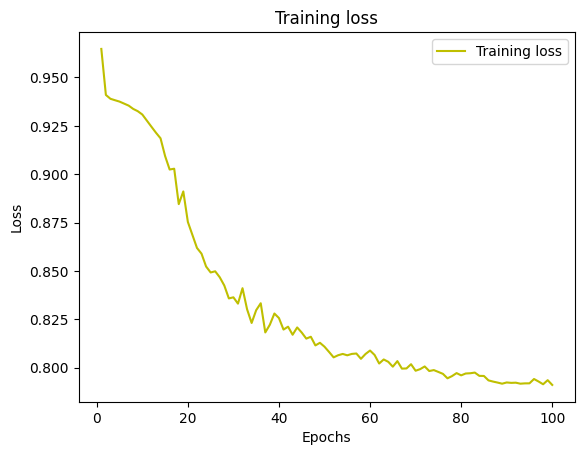

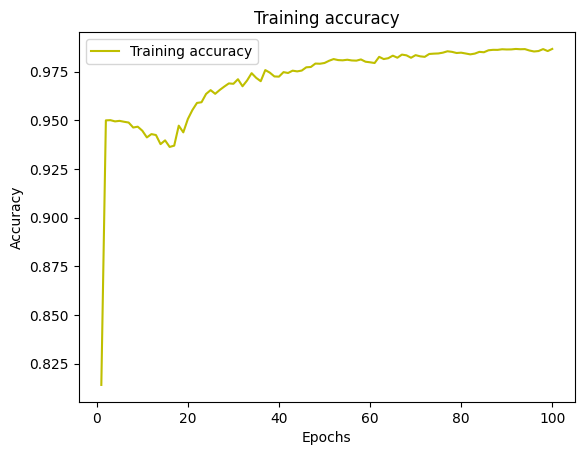

In [ ]:
import matplotlib.pyplot as plt


loss = history.history['loss']
acc = history.history['accuracy']


val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']


epochs = range(1, len(loss) + 1)


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()


In [ ]:
!unzip /content/zBraTS2020/BraTS20_Training_185.zip


Archive:  /content/zBraTS2020/BraTS20_Training_185.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/zBraTS2020/BraTS20_Training_185.zip or
        /content/zBraTS2020/BraTS20_Training_185.zip.zip, and cannot find /content/zBraTS2020/BraTS20_Training_185.zip.ZIP, period.


In [ ]:
import shutil


klasor_adı = '/content/npy'


shutil.rmtree(klasor_adı)

In [ ]:
model2.compile(optimizer = optim, loss=total_loss, metrics=metrics)

In [ ]:
history2 = model2.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=100,
          verbose=1,
          validation_steps=val_steps_per_epoch,
          )

Epoch 1/100
37/37 [==============================] - 44s 1s/step - loss: 0.9843 - accuracy: 0.7657 - iou_score: 0.1095
Epoch 2/100
37/37 [==============================] - 41s 1s/step - loss: 0.9506 - accuracy: 0.9605 - iou_score: 0.2297
Epoch 3/100
37/37 [==============================] - 41s 1s/step - loss: 0.9431 - accuracy: 0.9644 - iou_score: 0.2399
Epoch 4/100
37/37 [==============================] - 41s 1s/step - loss: 0.9416 - accuracy: 0.9657 - iou_score: 0.2406
Epoch 5/100
37/37 [==============================] - 41s 1s/step - loss: 0.9415 - accuracy: 0.9639 - iou_score: 0.2401
Epoch 6/100
37/37 [==============================] - 41s 1s/step - loss: 0.9414 - accuracy: 0.9632 - iou_score: 0.2399
Epoch 7/100
37/37 [==============================] - 41s 1s/step - loss: 0.9408 - accuracy: 0.9639 - iou_score: 0.2398
Epoch 8/100
37/37 [==============================] - 41s 1s/step - loss: 0.9402 - accuracy: 0.9663 - iou_score: 0.2402
Epoch 9/100
37/37 [=============================

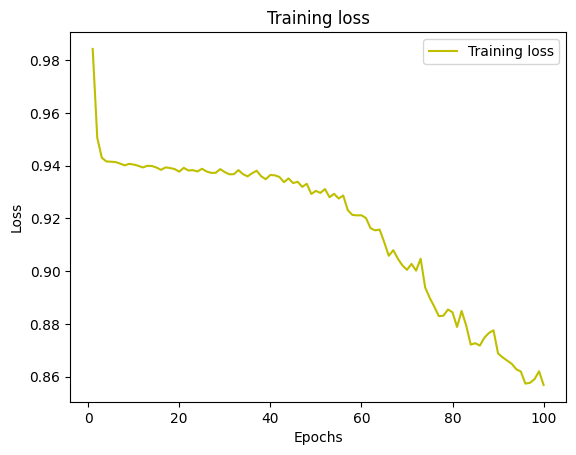

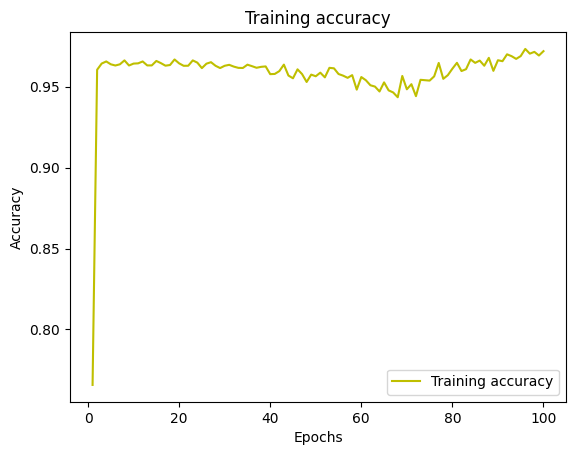

In [ ]:
loss = history2.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history2.history['accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
img_num = 15

test_img = np.load("/content/npy/images/image_"+str(img_num)+".npy")

test_mask = np.load("/content/npy/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=1)
test_prediction = model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]


In [ ]:
from matplotlib import pyplot as plt
import random


n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Teste')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Test')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Predictione')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()
